### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [54]:
from IPython.display import Image
%matplotlib inline
%run rf_analysis_utils.py
%run lending_dataprep.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

C:\Dev\Prog\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:171: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


Utility code in the associated file performs the following steps:
set random seed for the test_train_split
import packages and modules
defines a custom summary function: rstr()
create the list of variable names: var_names
create the list of features (var_names less class): features
import the lending.csv file
create the pandas dataframe and prints head: lending
create the categorical var encoder dictionary: le_dict
create a function to get any code for a column name and label: get_code
create the dictionary of categorical values: categories
creates the list of one hot encoded variable names, onehot_features
create the list of class names: class_names
create the pandas dataframe with encoded vars: lending_pre
create the pandas dataframe containing all features less class: X
create the pandas series containing the class 'decision': y
create the training and test sets: X_train, y_train, X_test, y_test
evaluate the training and test set priors and print them: train_priors, test_priors
crea

The data objects are now saved and given a set of generic names ease of use.

In [55]:
# get the correct directory for saved objects
pickle_dir_store = open("pickle_dir.pickle", "rb")
pickle_dir = pickle.load(pickle_dir_store)
pickle_dir_store.close()

# helper function for pickling files
def pickle_path(filename):
    return(pickle_dir + '\\' + filename)

# load up the training set (required because of running from script into Jup Note)
encoder_store = open(pickle_path('encoder.pickle'), "rb")
encoder = pickle.load(encoder_store)
encoder_store.close()

X_train_enc_store = open(pickle_path('X_train_enc.pickle'), "rb")
X_train_enc = pickle.load(X_train_enc_store)
X_train_enc_store.close()

y_train_store = open(pickle_path('y_train.pickle'), "rb")
y_train = pickle.load(y_train_store)
y_train_store.close()


In [56]:
%run rf_analysis_modelprep.py

Parameter tuning (disabled)
Utility code in the associated file performs the following steps:
set random seed for the random forest
fetch the best parameters from model tuning results

Best OOB Cohen's Kappa during tuning: 0.9690
Best parameters: {'n_estimators': 1400, 'max_depth': 16, 'min_samples_leaf': 1}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model


### Random Forest Performance

Cohen's Kappa on unseen instances: 0.9076
Confusion matrix, without normalization
[[ 4371   691]
 [   14 19330]]
Normalized confusion matrix
[[0.86 0.14]
 [0.   1.  ]]


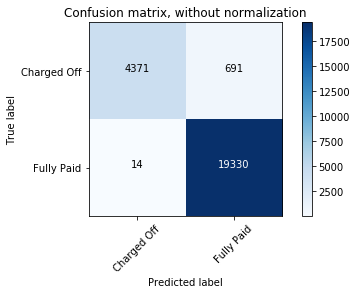

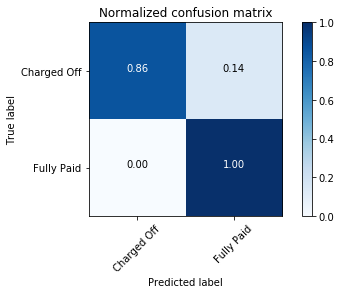

In [57]:
# test the model on unseen data
pred = enc_model.predict(X_test)
print("Cohen's Kappa on unseen instances: " "{:0.4f}".format(metrics.cohen_kappa_score(y_test, pred)))

# view the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
# normalized confusion matrix
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')

# Part 1. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [9]:
# First instantiate new survey class with the RF model
f_survey = forest_surveyor(model = rf, features = onehot_features, prediction_model = enc_model)

In [10]:
########################################################################
### This takes a few minutes, so only run when an update is required ###
########################################################################

if True:
    
    batch = X_test
    labels = y_test

    correct_preds = enc_model.predict(batch) == labels
    incorrect_preds = enc_model.predict(batch) != labels
    
    if sum(correct_preds) > 0:
        X = batch[correct_preds.values]
        y = labels[correct_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_cor_stats = f_survey.forest_stats(np.unique(y))
        
    if sum(incorrect_preds) > 0:
        X = batch[incorrect_preds.values]
        y = labels[incorrect_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_incor_stats = f_survey.forest_stats(np.unique(y))
    
    tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "wb")
    pickle.dump(f_cor_stats, tt_correct_stats_store)
    tt_correct_stats_store.close()
    
    tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "wb")
    pickle.dump(f_incor_stats, tt_incorrect_stats_store)
    tt_incorrect_stats_store.close()
    
    
tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "rb")
tt_correct_stats = pickle.load(tt_correct_stats_store)
tt_correct_stats_store.close()

tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "rb")
tt_incorrect_stats = pickle.load(tt_incorrect_stats_store)
tt_incorrect_stats_store.close()

MemoryError: 

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = onehot_features
)

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_child_traversals'],
                           denom = tt_correct_stats[0]['m_child_traversals'],
                           num_err = tt_correct_stats[1]['sd_child_traversals'],
                           denom_err = tt_correct_stats[0]['sd_child_traversals'],
                           labels = onehot_features)

log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_lower_traversals'],
                           denom = tt_correct_stats[0]['m_lower_traversals'],
                           num_err = tt_correct_stats[1]['sd_lower_traversals'],
                           denom_err = tt_correct_stats[0]['sd_lower_traversals'],
                           labels = onehot_features)

# Part 2. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [58]:
first_n = 5 # python is 'up to but not including'

batch = X_test[0:first_n]
labels = y_test[0:first_n]

preds = enc_model.predict(batch)

nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

paths = {}
for instance in range(first_n):
    paths[instance] = get_paths(nfp, instance, by_tree = False, which_trees='majority')

# there is a bug in sklearn causing all the warnings. This should be fixed in next release.
pretty_print_tree_votes(paths, preds, labels)

Instance 0:    True Class = 1 Fully Paid    Pred Class = 1 Fully Paid    Majority voting trees = 1385
Instance 1:    True Class = 0 Charged Off    Pred Class = 0 Charged Off    Majority voting trees = 943
Instance 2:    True Class = 0 Charged Off    Pred Class = 0 Charged Off    Majority voting trees = 1177
Instance 3:    True Class = 1 Fully Paid    Pred Class = 1 Fully Paid    Majority voting trees = 1374
Instance 4:    True Class = 1 Fully Paid    Pred Class = 1 Fully Paid    Majority voting trees = 1355


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

In [59]:
# profiling a single instance
instance = 1

# Collect useful data for instance
true_class = labels[instance:instance+1].values[0]
pred_probs = enc_model.predict_proba(batch[instance:instance + 1])[0]

print('Test instance id: ' + str(instance))
print('True class: ' + str(true_class))
print('Pedicted Class Probabilities ')
for c, n, p in zip(class_names, range(len(class_names)), pred_probs):
    print(n, c, "{:0.4f}".format(p))

# get the class codes produced by the model and the true class
true_class_code = get_label(class_col, true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_code(class_col, class_names[class_code_confs[0]])
second_class_code = get_code(class_col, class_names[class_code_confs[1]])

# Display instance row
germ_id = batch[instance:instance + 1].index[0]
lending[germ_id:germ_id + 1]

Test instance id: 1
True class: 0
Pedicted Class Probabilities 
0 Charged Off 0.6585
1 Fully Paid 0.3415


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,verification_status,issue_d,purpose,zip_code,...,disbursement_method,emp,block_missingness,fico,last_fico,non_funded_score,non_funded_inv_score,adj_log_dti,log_inc,loan_status
44409,5000.0,36.0,11.44,164.74,8.0,OWN,Not Verified,2457785.5,credit_card,241xx,...,Cash,U,0.0,702.0,532.0,0.0,0.0,3.015535,9.615872,Charged Off


In [69]:
get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False, which_trees='majority')
                                           , vars_dict, 4, equal_counts=True),
                                 support = 0.025, alpha = 0.4)                           

C:\Dev\Study\python\interpret_basics2\rf_analysis_utils.py:937: RuntimeWarning: invalid value encountered in true_divide
  if t == False: # greater than, lower bound
C:\Dev\Study\python\interpret_basics2\rf_analysis_utils.py:933: RuntimeWarning: invalid value encountered in true_divide
  for nodes in paths:


[((('total_rec_prncp', True, 3166.27),), 394, 3.5858105455787603),
 ((('total_pymnt', True, 4413.22), ('total_rec_prncp', True, 3166.27)),
  84,
  3.5446534390746507),
 ((('total_pymnt_inv', True, 4576.45), ('total_rec_prncp', True, 3166.27)),
  83,
  3.535072486237279),
 ((('term', True, 48.0), ('total_rec_prncp', True, 3166.27)),
  81,
  3.5155593237379517),
 ((('last_credit_pull_d', False, 2457645.02),
   ('total_rec_prncp', True, 3166.27)),
  80,
  3.505621307739105),
 ((('total_rec_late_fee', True, 3.71), ('total_rec_prncp', True, 3166.27)),
  75,
  3.453990490829048),
 ((('issue_d', False, 2457113.07), ('total_rec_prncp', True, 3166.27)),
  68,
  3.3756061641408857),
 ((('sub_grade', True, 10.91), ('total_rec_prncp', True, 3166.27)),
  63,
  3.3145077811132264),
 ((('total_rec_int', True, 1342.52), ('total_rec_prncp', True, 3166.27)),
  62,
  3.3017075080360736),
 ((('issue_d', False, 2457113.07), ('total_pymnt', True, 4413.22)),
  62,
  3.3017075080360736),
 ((('term', True, 48.

C:\Dev\Study\python\interpret_basics2\rf_analysis_utils.py:937: RuntimeWarning: invalid value encountered in true_divide
  if t == False: # greater than, lower bound
C:\Dev\Study\python\interpret_basics2\rf_analysis_utils.py:933: RuntimeWarning: invalid value encountered in true_divide
  for nodes in paths:


('total_rec_prncp', True, 3166.27) feature first added
('total_pymnt', True, 4413.22) feature first added
('total_rec_prncp', True, 3166.27) feature appears already
('total_rec_prncp', True, 3166.27) feature values appears already
('term', True, 48.0) feature first added
('total_rec_prncp', True, 3166.27) feature appears already
('total_rec_prncp', True, 3166.27) feature values appears already
('total_rec_late_fee', True, 3.71) feature first added
('total_rec_prncp', True, 3166.27) feature appears already
('total_rec_prncp', True, 3166.27) feature values appears already
('sub_grade', True, 10.91) feature first added
('total_rec_prncp', True, 3166.27) feature appears already
('total_rec_prncp', True, 3166.27) feature values appears already
('issue_d', False, 2457113.07) feature first added
('total_pymnt', True, 4413.22) feature appears already
('total_pymnt', True, 4413.22) feature values appears already
('total_pymnt_inv', True, 4576.45) feature first added
('last_fico', True, 612.17) 

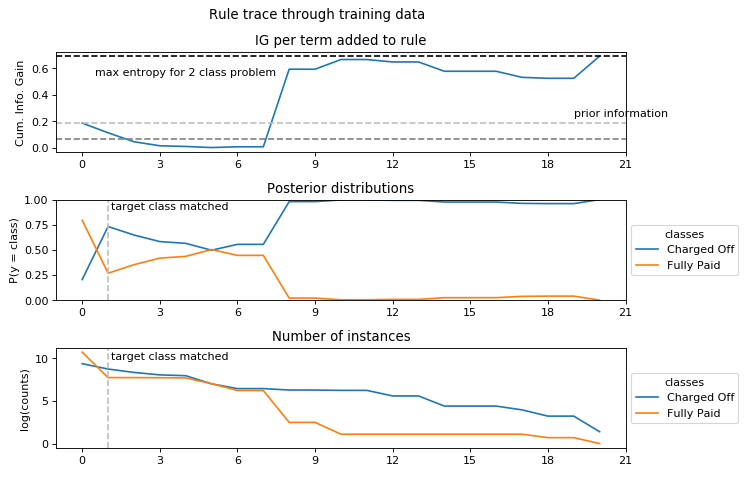

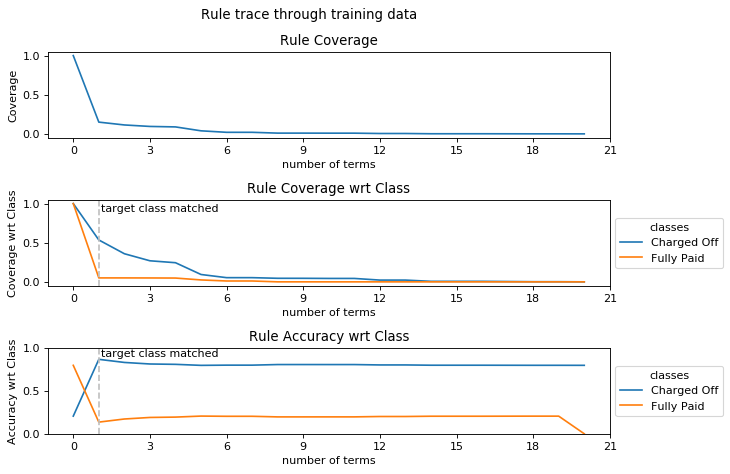

('total_rec_prncp', True, 3234.92) feature first added
('total_pymnt_inv', True, 4610.42) feature first added
('total_rec_prncp', True, 3234.92) feature appears already
('total_rec_prncp', True, 3234.92) feature values appears already
('last_credit_pull_d', False, 2457646.68) feature first added
('total_rec_prncp', True, 3234.92) feature appears already
('total_rec_prncp', True, 3234.92) feature values appears already
('total_rec_late_fee', True, 4.21) feature first added
('total_rec_prncp', True, 3234.92) feature appears already
('total_rec_prncp', True, 3234.92) feature values appears already
('last_pymnt_d', False, 2457919.74) feature first added
('total_rec_prncp', True, 3234.92) feature appears already
('total_rec_prncp', True, 3234.92) feature values appears already
('issue_d', False, 2457132.34) feature first added
('total_rec_prncp', True, 3234.92) feature appears already
('total_rec_prncp', True, 3234.92) feature values appears already
('term', True, 48.0) feature first added


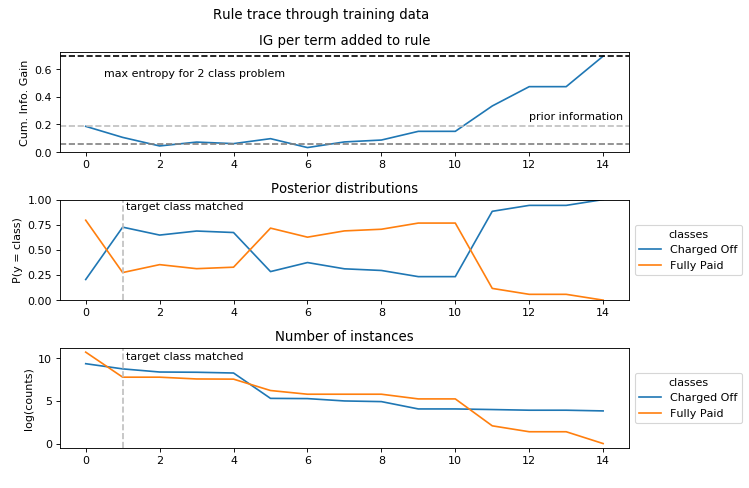

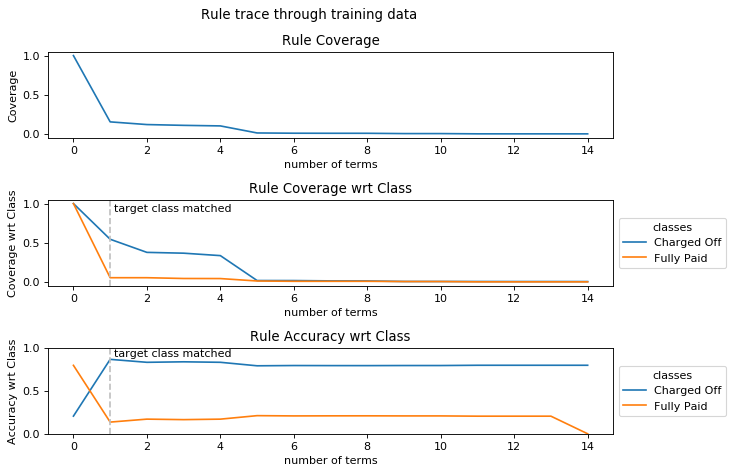

In [70]:
# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False
                                         , which_trees='majority')
                                           , vars_dict, 4, equal_counts=True),
                                 support = 0.025, alpha = 0.4)
# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_instance(instance=instance, target_class=0
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 1)

# MINORITY
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(discretize_paths(get_paths(nfp, instance, by_tree = False
                                                         , which_trees='minority')
                                           , vars_dict, 4, equal_counts=True),
                                 support = 0.025, alpha = 0.4) 

# create the rule accumulator
ra_min = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)

# run the profile
ra_min, model_votes = profile_instance(instance=instance, target_class=0
                                     , fp_object = nfp
                                     , rule_acc = ra_min
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 1)

In [71]:
pretty_print(ra.rule, onehot_dict)

['total_rec_prncp <= 3166.27',
 'total_pymnt <= 4413.22',
 'term <= 48.0',
 'total_rec_late_fee <= 3.71',
 'sub_grade <= 10.91',
 'issue_d > 2457113.07',
 'total_pymnt_inv <= 4576.45',
 'last_fico <= 612.17',
 'last_credit_pull_d > 2457645.02',
 'last_pymnt_amnt <= 611.73',
 'int_rate <= 14.02',
 'installment <= 231.75',
 'total_rec_int <= 1342.52',
 'verification_status_Not Verified True',
 'adj_log_dti <= 3.19',
 'log_inc <= 10.83',
 'last_pymnt_d > 2457892.06']

In [17]:
ra.prune_rule()
pretty_print(ra.pruned_rule, onehot_dict)

['last_fico <= 597.7',
 'total_pymnt_inv <= 4393.65',
 'issue_d > 2457037.3',
 'term <= 48.0',
 'last_pymnt_amnt <= 621.28',
 'total_rec_int <= 1367.81',
 'sub_grade <= 10.93',
 'total_rec_late_fee <= 3.88',
 'last_pymnt_d > 2457898.83',
 'verification_status_Not Verified True',
 'int_rate <= 13.66',
 'acc_open_past_24mths <= 4.63']

In [18]:
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([9], dtype=int64),
 'labels': array([0], dtype=int64),
 'p_counts': array([1.])}

In [23]:
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)
for i in range(3):
    ra.add_rule()
ra.prune_rule()
pretty_print(ra.pruned_rule, onehot_dict)
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

('last_fico', True, 632.28) feature first added
('total_pymnt_inv', True, 4393.65) feature first added
('issue_d', False, 2457037.3) feature first added


{'counts': array([2518,  143], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.9462608, 0.0537392])}

In [ ]:
ra.pruned_rule

In [ ]:
p_count(training_labels.loc[apply_rule([
 ('crhis_A30', True, 0.5),
 ('crhis_A31', True, 0.5),
 ('job_A174', False, 0.5),
 ('tel_A192', False, 0.5),
 ('emp_A75', False, 0.5),
 #('pers_A93', False, 0.5),
 ('chk_A12', False, 0.5)
], encoder.transform(training_data), onehot_features)].values)

In [ ]:
p_count(training_labels.loc[apply_rule(ra4.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
pretty_print(ra_min.rule)

In [ ]:
ra_min.prune_rule()
pretty_print(ra_min.pruned_rule)

In [ ]:
p_count(training_labels.loc[apply_rule(ra_min.pruned_rule, encoder.transform(training_data), onehot_features)].values)

In [ ]:
pretty_print(ra_min.tight_rule)

In [ ]:
p_count(training_labels.loc[apply_rule(ra_min.tight_rule, encoder.transform(training_data), onehot_features)].values)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()

In [64]:
%run rf_analysis_utils.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv